## Set-up

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q datasets seqeval

In [5]:
!pip install accelerate -U

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("darentang/sroie")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 626
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 347
    })
})

In [9]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None)}

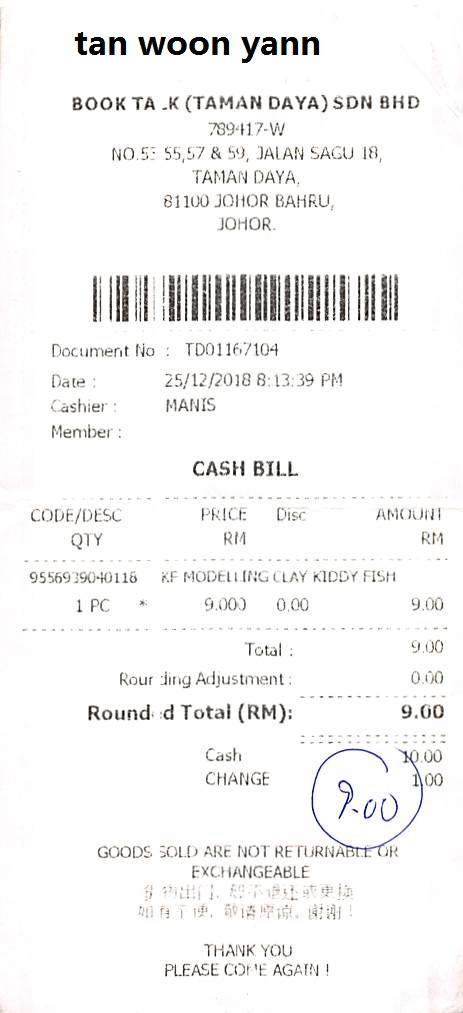

In [10]:
from PIL import Image

example = dataset["train"][0]
image = Image.open(example["image_path"])
image

In [11]:
words, boxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['tan', 'woon', 'yann', 'BOOK', 'TA', '_K', '(TAMAN', 'DAYA)', 'SDN', 'BHD', '789417-W', 'NO.5:', '55,57', '&', '59,', 'JALAN', 'SAGU', '18,', 'TAMAN', 'DAYA,', '81100', 'JOHOR', 'BAHRU', 'JOHOR.', 'Document', 'No', ':', 'TD01167104', 'Date', ':', '25/12/2018', '8:13:39', 'PM', 'Cashier', ':', 'MANIS', 'Member', ':', 'CASH', 'BILL', 'CODE/DESC', 'PRICE', 'Disc', 'AMOUNT', 'QTY', 'RM', 'RM', '9556939040118', 'KF', 'MODELLING', 'CLAY', 'KIDDY', 'FISH', '1', 'PC', '9.000', '0,00', '9,00', 'Total', ':', '9.00', 'Rour', 'ding', 'Adjustment', ':', '0,00', 'Round', 'd', 'Total', '(RM):', '9.00', 'Cash', '10.00', 'CHANGE', '1.00', '9:00', 'GOODS', 'SOLD', 'ARE', 'NOT', 'RETURNABLE', 'OR', 'EXCHANGEABLE', 'THANK', 'YOU', 'PLEASE', 'COME', 'AGAIN', '!']
[[157, 29, 280, 58], [293, 30, 503, 60], [518, 32, 697, 61], [151, 92, 276, 111], [282, 91, 332, 111], [339, 91, 384, 111], [390, 90, 565, 111], [572, 90, 708, 111], [714, 90, 807, 110], [814, 91, 909, 110], [447, 117, 615, 135], [237, 143, 339, 

## Prepare dataset

In [12]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [13]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"
text_column_name = "words"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [14]:
print(label_list)

['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS', 'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']


In [15]:
print(id2label)

{0: 'O', 1: 'B-COMPANY', 2: 'I-COMPANY', 3: 'B-DATE', 4: 'I-DATE', 5: 'B-ADDRESS', 6: 'I-ADDRESS', 7: 'B-TOTAL', 8: 'I-TOTAL'}


In [16]:
import numpy as np

def convert_paths_to_numpy(image_paths):
  np_images_list = []
  for path in image_paths:
      image_array = np.asarray(Image.open(path))

      # adding third dimenstion for grayscale images
      if len(image_array.shape) != 3:
        image_array = np.dstack((image_array, image_array, image_array))

      np_images_list.append(image_array)

  return np_images_list

def prepare_examples(examples):
  images = convert_paths_to_numpy(examples[image_column_name])
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [17]:
# some images have only 2 dims
# two_dims_images_train = []
# two_dims_images_test = []

# for image in dataset['train']['image_path']:
#   if len(np.asarray(Image.open(image)).shape) != 3:
#     two_dims_images_train.append(image)

# for image in dataset['test']['image_path']:
#   if len(np.asarray(Image.open(image)).shape) != 3:
#     two_dims_images_test.append(image)

# two_dims_images_train, two_dims_images_test

In [18]:
# bad_image_ex = np.asarray(Image.open(two_dims_images_train[0]))
# print(bad_image_ex.shape, len(bad_image_ex.shape))
# bad_image_rgb = np.dstack((bad_image_ex, bad_image_ex, bad_image_ex))
# print(bad_image_rgb.shape)

In [19]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

In [20]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 626
})

In [21]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> tan woon yann BOOK TA _K (TAMAN DAYA) SDN BHD 789417-W NO.5: 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU JOHOR. Document No : TD01167104 Date : 25/12/2018 8:13:39 PM Cashier : MANIS Member : CASH BILL CODE/DESC PRICE Disc AMOUNT QTY RM RM 9556939040118 KF MODELLING CLAY KIDDY FISH 1 PC 9.000 0,00 9,00 Total : 9.00 Rour ding Adjustment : 0,00 Round d Total (RM): 9.00 Cash 10.00 CHANGE 1.00 9:00 GOODS SOLD ARE NOT RETURNABLE OR EXCHANGEABLE THANK YOU PLEASE COME AGAIN!</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [22]:
train_dataset.set_format("torch")

Verifying that everything was created properly

In [23]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [24]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 347
})

In [25]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> tan chay yee *** COPY *** OJC MARKETING SDN BHD ROC NO: 538358-H NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, 81750 MASAI, JOHOR Tel:07-388 2218 Fax:07-388 8218 Email: ng@ojcgroup.com TAX INVOICE Invoice No : PEGIV-1030765 Date : 15/01/2019 11:05:16 AM Cashier : NG CHUAN MIN Sales Persor : FATIN Bill To : THE PEAK QUARRY WORKS Address Description Qty Price Amount 000000111 1 193.00 193.00 SR KINGS SAFETY SHOES KWD 805 Qty: 1 Total Exclude GST: 193.00 Total GST @6%: 0.00 Total Inclusive GST: 193.00 Round Amt: 0.00 TOTAL: 193.00 VISA CARD 193,00 xxxxxxxxxxxxxxxx4318 Approval Code:000 93.00 Goods Sold Are Not Returnable & Refundable **** Thank You. Please Come Again.****</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [26]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 tan 0
 w 0
oon -100
 y 0
ann -100
 BOOK 1
 TA 2
 _ 2
K -100
 ( 2
T -100
AM -100
AN -100
 DAY 2
A -100
) -100
 SD 2
N -100
 B 2
HD -100
 7 5
89 -100
417 -100
- -100
W -100
 NO 6
. -100
5 -100
: -100
 55 6
, -100
57 -100
 & 6
 59 6
, -100
 J 6
AL -100
AN -100
 S 6
AG -100
U -100
 18 6
, -100
 TAM 6
AN -100
 DAY 6
A -100
, -100
 8 6
1100 -100
 J 6
OH -100
OR -100
 BA 6
HR -100
U -100
 J 6
OH -100
OR -100
. -100
 Document 0
 No 0
 : 0
 TD 0
01 -100
167 -100
104 -100
 Date 0
 : 0
 25 3
/ -100
12 -100
/ -100
2018 -100
 8 0
: -100
13 -100
: -100
39 -100
 PM 0
 Cash 0
ier -100
 : 0
 MAN 0
IS -100
 Member 0
 : 0
 C 0
ASH -100
 B 0
ILL -100
 CODE 0
/ -100
DES -100
C -100
 PR 0
ICE -100
 Disc 0
 AM 0
OUNT -100
 Q 0
TY -100
 RM 0
 RM 0
 9 0
55 -100
69 -100
39 -100
04 -100
01 -100
18 -100
 K 0
F -100
 M 0
ODE -100
LL -100
ING -100
 CL 0
AY -100
 K 0
ID -100
D -100
Y -100
 F 0
ISH -100
 1 0
 PC 0
 9 7
. -100
000 -100
 0 0
, -100
00 -100
 9 0
, -100
00 -100
 Total 0
 : 0
 9 0
. -100
00 -100

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [27]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-27-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [28]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [33]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

## Train the model


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.119117,0.709600,0.639049,0.672479,0.973196
200,No log,0.068467,0.771162,0.774496,0.772825,0.980497
300,No log,0.053524,0.733838,0.907781,0.811594,0.984259
400,No log,0.047187,0.800000,0.919308,0.855515,0.987303
500,0.128100,0.042530,0.832789,0.918588,0.873587,0.989605
600,0.128100,0.036440,0.833118,0.927954,0.877982,0.990694
700,0.128100,0.036440,0.852220,0.926513,0.887815,0.991486
800,0.128100,0.034977,0.877800,0.931556,0.903880,0.992179
900,0.128100,0.034331,0.865385,0.940202,0.901243,0.992352
1000,0.031000,0.032418,0.890027,0.938761,0.913745,0.992996


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.07955423545837402, metrics={'train_runtime': 918.7876, 'train_samples_per_second': 2.177, 'train_steps_per_second': 1.088, 'total_flos': 527220135936000.0, 'train_loss': 0.07955423545837402, 'epoch': 3.19})

## Saving model

In [ ]:
trainer.save_model('/content/drive/MyDrive/layoutmv3_checkpoint')

In [31]:
# load model
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("/content/drive/MyDrive/layoutmv3_checkpoint")

## Evaluate the model


In [34]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.03241795673966408,
 'eval_precision': 0.8900273224043715,
 'eval_recall': 0.9387608069164265,
 'eval_f1': 0.9137447405329594,
 'eval_accuracy': 0.992995742995743,
 'eval_runtime': 1430.4833,
 'eval_samples_per_second': 0.243,
 'eval_steps_per_second': 0.122}

## Inference

You can load the model for inference as follows: